## Dataset

In [115]:
import pandas as pd

games = pd.read_csv('../data/dataframe.csv')

### Features

In [116]:
# version 1, all usable variables
# features = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'FT_PCT_avg_N_HOME', 'FT_PCT_avg_N_AWAY', 'FG3_PCT_avg_N_HOME',
#        'FG3_PCT_avg_N_AWAY', 'REB_avg_N_HOME', 'REB_avg_N_AWAY',
#        'AST_avg_N_HOME', 'AST_avg_N_AWAY', 'home_team_elo', 'away_team_elo',
#        'elo_difference']
# verison 2, only features created by us
# features = ['FT_PCT_avg_N_HOME', 'FT_PCT_avg_N_AWAY', 'FG3_PCT_avg_N_HOME',
#        'FG3_PCT_avg_N_AWAY', 'REB_avg_N_HOME', 'REB_avg_N_AWAY',
#        'AST_avg_N_HOME', 'AST_avg_N_AWAY', 'home_team_elo', 'away_team_elo',
#        'elo_difference']
# version 3, only elo_difference to indicate elo
# features = ['FT_PCT_avg_N_HOME', 'FT_PCT_avg_N_AWAY', 'FG3_PCT_avg_N_HOME',
#        'FG3_PCT_avg_N_AWAY', 'REB_avg_N_HOME', 'REB_avg_N_AWAY',
#        'AST_avg_N_HOME', 'AST_avg_N_AWAY', 'elo_difference']
# version 4, two variables for elo
features = ['FT_PCT_avg_N_HOME', 'FT_PCT_avg_N_AWAY', 'FG3_PCT_avg_N_HOME',
       'FG3_PCT_avg_N_AWAY', 'REB_avg_N_HOME', 'REB_avg_N_AWAY',
       'AST_avg_N_HOME', 'AST_avg_N_AWAY', 'home_team_elo', 'elo_difference']


# Separate the features and the target
X = games[features]
y = games['HOME_TEAM_WINS']

### Versions Assessment

#### 1 vs 2

The additional "artificial" variables in version 1 seem to confuse the models more than helping. With artificial variables we mean all variables which don't contain direct statistics from the game; like "GAME_ID" which is an arbitrary number to uniquely indentify a game, even if through this variable games are ordered from oldest to newest this doesn't seem be much useful.

#### 2 vs 3 vs 4
Using respecively three, one and two variables for elo. Semplicity is always preferable but unfortunately the version with all three variables is consistently better than the others. Nontheless using two variables ('elo_difference' and 'home_team_elo') has result almost identical to using three, while using one has slightly worse results. Using version 4 is probably the best balance between semplicity and effectivness.
|# variables|3|2|1|
|-------|--|--|--|
|Version|#2|#4|#3|
|Accuracy|0.66325|0.66317|0.6619|


### Feature Scaling

disabled since version 2.

In [117]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()
# # Fit the scaler to the features
# scaler.fit(X)
# # Transform the features using the scaler
# X_scaled = scaler.transform(X)

### Splitting

In [118]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models

### Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

rdf = RandomForestClassifier(n_estimators=100)  
# n_estimator=1000 better accuracy but too much time
rdf.fit(X_train, y_train)

RandomForestClassifier()

#### Feature Importance

In [120]:
# Get the feature importances
importances = rdf.feature_importances_
# link with features names
importances = zip(importances, X.columns)
# Sort the feature importances in descending order
sorted_importances = sorted(importances, reverse=True, key=lambda x:abs(x[0]))

# Print the feature names and importances
for importance, feature in sorted_importances:
    print(f"{feature}: {importance:.2f}")

elo_difference: 0.18
home_team_elo: 0.12
FG3_PCT_avg_N_AWAY: 0.09
FG3_PCT_avg_N_HOME: 0.09
FT_PCT_avg_N_HOME: 0.09
FT_PCT_avg_N_AWAY: 0.09
REB_avg_N_HOME: 0.08
AST_avg_N_HOME: 0.08
REB_avg_N_AWAY: 0.08
AST_avg_N_AWAY: 0.08


### Naive Bayes

In [121]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

#### Permutation Importance

The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.  
From [scikit](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)


In [122]:
from sklearn.inspection import permutation_importance

# Get the Permutation importance
imps = permutation_importance(gnb, X_test, y_test)
# link with features names
imps = zip(imps.importances_mean, X.columns)
# Sort the permutation importances in descending order
sorted_imps = sorted(imps, reverse=True, key=lambda x:abs(x[0]))

# Print the feature names and importances
for importance, feature in sorted_imps:
    print(f"{feature}: {importance:.10f}") 


elo_difference: 0.0601545473
home_team_elo: 0.0249256984
FG3_PCT_avg_N_HOME: 0.0026154151
REB_avg_N_AWAY: 0.0016643551
REB_avg_N_HOME: 0.0011095700
FG3_PCT_avg_N_AWAY: 0.0010303150
FT_PCT_avg_N_HOME: 0.0009510600
AST_avg_N_HOME: 0.0007529225
FT_PCT_avg_N_AWAY: -0.0005944125
AST_avg_N_AWAY: -0.0001585100


### Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression

lrg = LogisticRegression(penalty=None)

`penalty='l2'` is very close but consistently worse. By GridSearchCV.

|params|None|l2|
|------|----|--|
|mean_test_AUC|0.69534876|0.69481222|
|mean_train_AUC|0.69622475|0.69620209|
|mean_test_Accuracy|0.66015328|0.65864726|
|mean_train_Accuracy|0.65961871|0.65985651|

In [124]:
lrg.fit(X_train, y_train)

LogisticRegression(penalty=None)

#### Feature Importance

We look at the coefficient and we multiply them to the stadard deviation of the corresponding parameter in the data.  
From [stackoverflow](https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model)

In [125]:
import numpy as np

# Get the feature importances
importances = np.std(X_train, 0)*lrg.coef_[0,]
# link with features names
importances = zip(importances, X.columns)
# Sort the feature importances in descending order
sorted_importances = sorted(importances, reverse=True, key=lambda x:abs(x[0]))

# Print the feature names and importances
for importance, feature in sorted_importances:
    print(f"{feature}: {importance:.20f}")

elo_difference: 0.71766996286288953222
home_team_elo: 0.08572317997177118787
AST_avg_N_AWAY: -0.07213259414809727876
AST_avg_N_HOME: 0.02466554532084615226
REB_avg_N_AWAY: -0.02345367967941616727
REB_avg_N_HOME: -0.00112668277656587275
FG3_PCT_avg_N_HOME: 0.00000618398175250869
FG3_PCT_avg_N_AWAY: -0.00000580517596584074
FT_PCT_avg_N_AWAY: -0.00000535630735717583
FT_PCT_avg_N_HOME: 0.00000249080335943797


### Dummy Classfier

In [126]:
from sklearn.dummy import DummyClassifier

dmc = DummyClassifier(strategy='most_frequent', random_state=42)

dmc.fit(X_train, y_train)


DummyClassifier(random_state=42, strategy='most_frequent')

## Assessment

### Cross Validation

In [127]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def cross_validation(model, X, y, cvn=10):
    """
    Proxy for cross validation
    """
    scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = cvn))
    return scores.mean(), scores.std()

### Classification Matrices

In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_data(model, X_test, y_test, name):
    """
    Compute the confusion matrix of the given model.
    Export a graph for the matrix. 
    Return confusion matrix array containing tn, fp, fn and tp.
    """
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
    # export graph
    disp.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_confusion_matrix')

    return cm

### ROC Curves

In [129]:
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

def roc_data(y, pred, name):
    """
    Compute ROC information for the given model. 
    Export a graph for the curve. Return AUC value.
    """
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                              estimator_name='wins')
    # export graph
    display.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_roc')

    return roc_auc

### FNR, FPR

In [130]:
def fpr_fnr_data(cm):
    """
    Compute False Positive Rate and False Negative Rate from confusion matrix.
    """
    # the confusion matrix has True Negative, False Positive, False Negative 
    # and True Positive info.
    tn, fp, fn, tp = cm.ravel() # .ravel() flattens the array to a 1-Dimension array

    # To get the total number of wins and losses we count the ones and zeroes, 
    # respectively, from the Target variable.
    wins, losses = y.value_counts()

    fpr = fp/losses     # FPR = FP/N
    fnr = fn/wins       # FNR = FN/P

    return fpr, fnr

### Final Assessment

In [131]:
import json
from os import path

def indexes(model, y, X_test, y_test, name):
    """
    Compute accuracy, FPR, FNR, confusion matrix and ROC curve.
    Exports two images, one for the confusion matrix anthe other for ROC; 
    all other indexes are added to a json file.
    """
    # Indexes computation
    accuracy = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 10))    # accuracy
    cm = confusion_matrix_data(model, X_test, y_test, name)             # confusion matrix
    fpr, fnr = fpr_fnr_data(cm)                                         # False Positive Rate, False Negative Rate
    area_under_curve = roc_data(y, model.predict_proba(X)[:, 1], name)  # Receiver Operating Characteristic curve and Area Under the Curve
    
    # Indexes export handling
    json_filename = '../iterations_evaluation/iterations.json'

    if path.isfile(json_filename) is True:  # file exists
        # get json file
        with open(file=json_filename,mode='r') as f: # read mode
            all_indexes = json.load(f)  # json file is translated to a python dictionary
    else:   # file does not exists
        with open(file=json_filename,mode='x') as f: # create mode
            all_indexes = dict()    # create an empty dictionary
    # add new indexes to dictionary
    all_indexes.update({
        name: {
            'accuracy': [accuracy.mean(), accuracy.std()],
            'confusion_matrix': [x.item() for x in cm.ravel()], # cm is numpy.ndarray and its elements are numpy.int64; both types aren't "JSON Serialiazable" so they have to be translated to native Python types
            'FPR': fpr,
            'FNR': fnr,
            'AUC': area_under_curve
        }
    })
    # rewrite file with new indexes
    with open(file=json_filename,mode='w') as f:
        json.dump(all_indexes, f, indent=4, separators=(',',': '))
    
    return accuracy, cm, fpr, fnr, area_under_curve

[0. 1.] [0. 1.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.89323946e-04 2.89323946e-04 8.67971839e-04 1.25373710e-03
 2.21815026e-03 2.98968078e-03 3.85765262e-03 4.91850709e-03
 6.26868550e-03 7.23309866e-03 8.58327708e-03 1.01263381e-02
 1.14765165e-02 1.29231363e-02 1.46590799e-02 1.62985823e-02
 1.82274086e-02 2.04455589e-02 2.21815026e-02 2.44960941e-02
 2.65213618e-02 2.94146012e-02 3.28864886e-02 3.52010801e-02
 3.71299065e-02 3.98302633e-02 4.26270614e-02 4.54238596e-02
 4.90886296e-02 5.28498409e-02 5.65146109e-02 5.98900569e-02
 6.23975311e-02 6.56765358e-02 6.88590992e-02 7.34882824e-02
 7.75388176e-02 8.08178224e-02 8.47719163e-02 8.96904234e-02
 9.32587520e-02 9.73092873e-02 1.01745588e-01 1.06664095e-01
 1.11775485e-01 1.17079757e-01 1.21130292e-01 1.24505738e-01
 1.29424245e-01 1.32992574e-01 1.37043109e-01 1.41768734e-01
 1.46976565e-01 1.50255569e-01 1.53631016e-01 1.58742405e-01
 1.64528

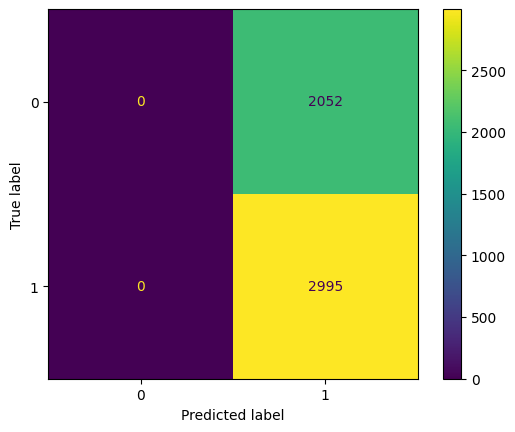

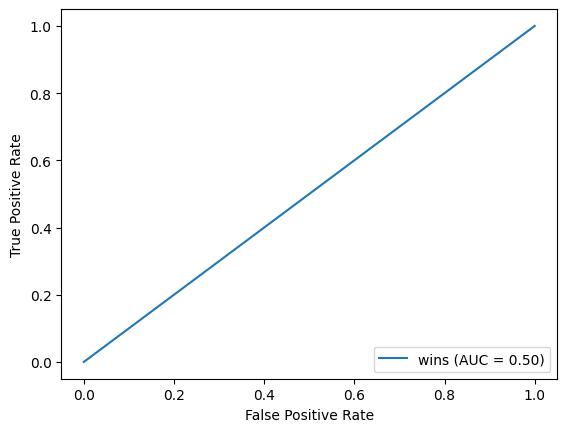

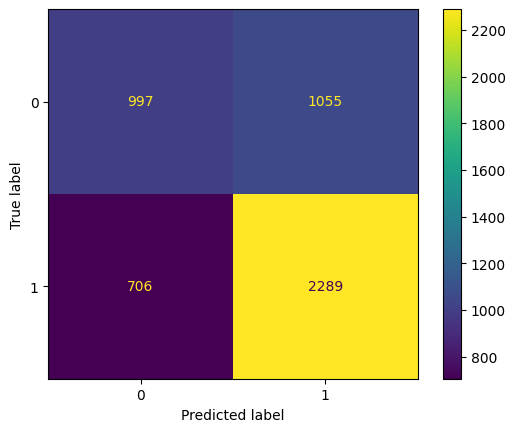

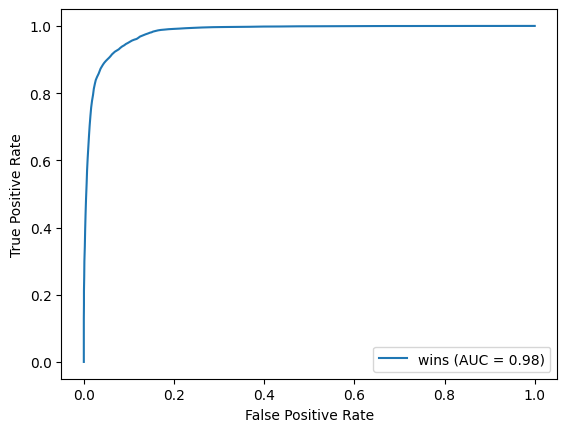

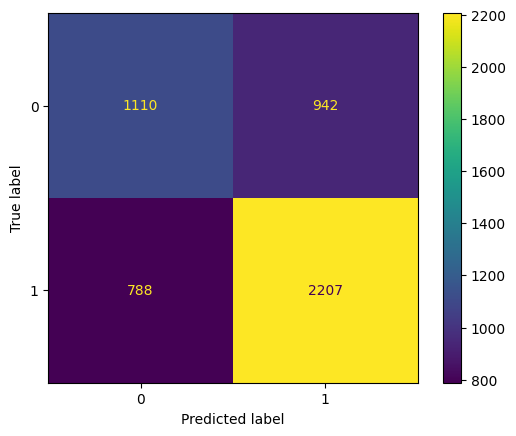

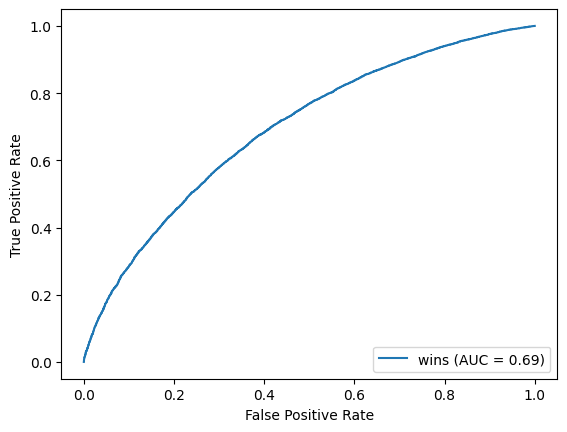

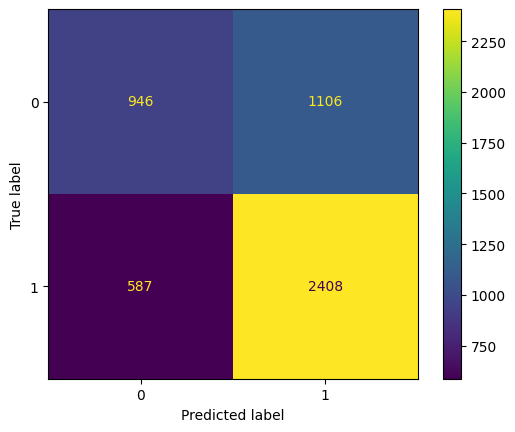

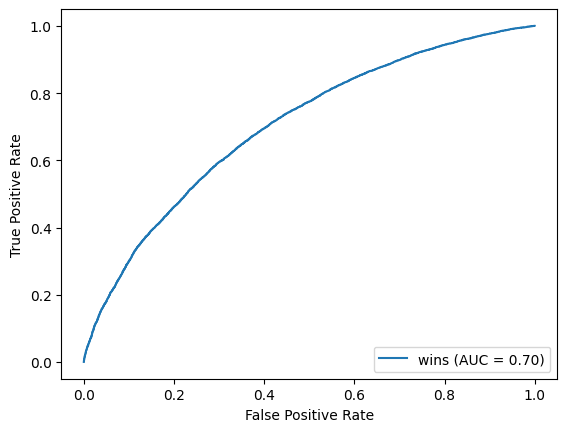

In [132]:
dummy = indexes(dmc, y, X_test, y_test, 'dummy_v4_noScaling')
randomFor = indexes(rdf, y, X_test, y_test, 'RndFor_v4_noScaling')
NaiveBayes = indexes(gnb, y, X_test, y_test, 'NaiveBayes_v4_noScaling')
LogisticRegres = indexes(lrg, y, X_test, y_test, 'LogiRegre_v4_noScaling')